In [ ]:
from google.colab import drive
drive.mount("/content/driveG")

Mounted at /content/driveG


In [ ]:
import torch
import torchvision

from torch import nn
from torchvision import transforms
from driveG.MyDrive.GP1.Graduation_Project_PCOS.going_modular import data_setup, engine
import matplotlib

In [ ]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


##### Added this block on to the vscode file

[INFO] Couldn't find torchinfo... installing it.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Setup path to PCOS data directory
from pathlib import Path

data_path = Path("/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/")
image_path = data_path / "newER_data"
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"{image_path} directory not found")

/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data directory exists.


In [ ]:
# Setup Directories
train_dir = image_path / "train"
test_dir = image_path / "validation"

# Create transformations and Dataloaders

In [ ]:
# Create transforms pipeline manually (older method)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224
    transforms.ToTensor(), # Turn pixel values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]), # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel)
    transforms.Grayscale() ##### change number of color channels from 3 to 1 (I added this)
])

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f2f4ba2d690>,
 ['infected', 'notinfected'])

# Loading my trained DenseNet201 model...

In [ ]:
FILE = "/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/DenseNet201_model0.pth"
Dense201 = torch.load(FILE, map_location=torch.device('cpu'))

summary(Dense201,
        input_size=(32, 1, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [32, 1, 224, 224]    [32, 1]              --                   Partial
├─Sequential (features)                       [32, 1, 224, 224]    [32, 1920, 7, 7]     --                   False
│    └─Conv2d (conv0)                         [32, 1, 224, 224]    [32, 64, 112, 112]   (3,136)              False
│    └─BatchNorm2d (norm0)                    [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ReLU (relu0)                           [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (pool0)                      [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─_DenseBlock (denseblock1)              [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─_DenseLayer (denselayer1)         [32, 64, 56, 56]     [32, 32, 56, 

# How fast is our model at predicting?
##One of the criteria for our deployed model is to be fast (30 FPS). Ideally, if we're deploying our PCOS detector model to a mobile device so doctors/people can upload photos of their Ultrasound images and identify it, we'd like the predictions to happen at real-time (~30 frames per second).
## To find out how long each of our models take to performance inference, let's create a function called `pred_and_store()` to iterate over each of the test dataset images one by one and perform a prediction. We'll time each of the predictions as well as store the results in a common prediction format: a list of dictionaries (where each element in the list is a single prediction and each sinlge prediction is a dictionary).

Note: We time the predictions one by one rather than by batch because when our model is deployed, it will likely only be making a prediction on one image at a time. As in, someone takes a photo and our model predicts on that single image.

## Since we'd like to make predictions across all the images in the test set, let's first get a list of all of the test image paths so we can iterate over them. To do so, we'll use Python's `pathlib.Path("target_dir").glob("*/*.jpg"))` to find all of the filepaths in a target directory with the extension .jpg (all of our test images).

In [ ]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: /content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation


[PosixPath('/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/infected/pco_1.jpg'),
 PosixPath('/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/infected/pco_7.jpg'),
 PosixPath('/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/infected/pco_13.jpg'),
 PosixPath('/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/infected/pco_4.jpg'),
 PosixPath('/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/infected/19_pco_1.jpg')]

Now we've got a list of our test image paths, let's get to work on our `pred_and_store()` function:

1. Create a function that takes a list of paths, a trained PyTorch model, a series of transforms (to prepare images), a list of target class names and a target device.
2. Create an empty list to store prediction dictionaries (we want the function to return a list of dictionaries, one for each prediction).
3. Loop through the target input paths (steps 4-14 will happen inside the loop).
4. Create an empty dictionary for each iteration in the loop to store prediction values per sample.
5. Get the sample path and ground truth class name (we can do this by infering the class from the path).
6. Start the prediction timer using Python's `timeit.default_timer()`.
7. Open the image using `PIL.Image.open(path)`.
8. Transform the image so it's capable of being used with the target model as well as add a batch dimension and send the image to the target device.
9. Prepare the model for inference by sending it to the target device and turning on `eval()` mode.
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and calculate the prediction probability using `torch.sigmoid()` and the target label using `torch.round()`.
11. Add the prediction probability and prediction class to the prediction dictionary created in step 4. Also make sure the prediction probability is on the CPU so it can be used with non-GPU libraries such as NumPy and pandas for later inspection.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary created in step 4.
13. See if the predicted class matches the ground truth class from step 5 and add the result to the prediction dictionary created in step 4.
14. Append the updated prediction dictionary to the empty list of predictions created in step 2.
15. Return the list of prediction dictionaries.




In [ ]:
from pathlib import Path
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
  # 2. create an empty list to store prediction dictionaries
  pred_list = []
  correct_preds_counter = 0

  # 3. Loop through target paths
  for path in tqdm(paths):

    # 4. Create an empty dictionary to store prediction information for each sample
    pred_dict = {}

    # 5. Get the sample path and ground truth class name
    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # 6. Start the prediction timer
    start_time = timer()

    # 7. Open the image
    img = Image.open(path)

    # 8. Transform the image, add batch dimension and put image on target device
    transformed_image = transform(img).unsqueeze(0).to(device)

    # 9. Prepare model for inference by sending it to target device and turning on eval() mode
    model.to(device)
    model.eval()

    # 10. Get prediction probability, prediction label and prediction class
    with torch.inference_mode():
      pred_logit = model(transformed_image).squeeze() # perform inference on target sample
      pred_prob = torch.sigmoid(pred_logit) # turn logit into prediction probability
      pred_label = torch.round(pred_prob) # turn prediction probability into prediction label
      pred_label = pred_label.type(torch.int64) # I had to cast pred_label to int b/c the following line required pred_label to be int
      #print(pred_label)
      pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

      # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      # 12. End the timer and calculate time per pred
      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time - start_time, 4)

    # 13. Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    if class_name == pred_class:
      correct_preds_counter += 1

    # 14. Add the dictionary to the list of preds
    pred_list.append(pred_dict)

  print(f"Out of {len(paths)} images, the model predicted {correct_preds_counter} correctly")

  # 15. Return list of prediction dictionaries
  return pred_list

# Making and timing predictions with trained DenseNet201 using `pred_and_store()` :

In [ ]:
DenseNet201_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                             model=Dense201,
                                             transform=manual_transforms,
                                             class_names=class_names,
                                             device="cpu") # Make predictions on CPU,  because when we deploy our model, we won't always have access to a "cuda" (GPU) device.

  0%|          | 0/252 [00:00<?, ?it/s]

Out of 252 images, the model predicted 172 correctly


In [ ]:
# Inspect the last 2 prediction dictionaries
DenseNet201_test_pred_dicts[-2:]

[{'image_path': PosixPath('/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/notinfected/8_normal_10.jpg'),
  'class_name': 'notinfected',
  'pred_prob': 0.613,
  'pred_class': 'notinfected',
  'time_for_pred': 0.5847,
  'correct': True},
 {'image_path': PosixPath('/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/notinfected/8_normal_38.jpg'),
  'class_name': 'notinfected',
  'pred_prob': 0.6026,
  'pred_class': 'notinfected',
  'time_for_pred': 0.6643,
  'correct': True}]

# Turn our list of dictionaries into a Pandas dataframe:

In [ ]:
import pandas as pd
DenseNet201_test_pred_df = pd.DataFrame(DenseNet201_test_pred_dicts)
DenseNet201_test_pred_df.tail()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
247,/content/driveG/MyDrive/GP1/After_Research_pap...,notinfected,0.7081,notinfected,0.6507,True
248,/content/driveG/MyDrive/GP1/After_Research_pap...,notinfected,0.8859,notinfected,0.6852,True
249,/content/driveG/MyDrive/GP1/After_Research_pap...,notinfected,0.6413,notinfected,0.7197,True
250,/content/driveG/MyDrive/GP1/After_Research_pap...,notinfected,0.6130,notinfected,0.5847,True
251,/content/driveG/MyDrive/GP1/After_Research_pap...,notinfected,0.6026,notinfected,0.6643,True


Look how easily those prediction dictionaries turn into a structured format we can perform analysis on. Such as finding how many predictions our DenseNet201 model got wrong.

In [ ]:
# Check number of correct predictions
DenseNet201_test_pred_df.correct.value_counts()

True     172
False     80
Name: correct, dtype: int64

So 80 wrong predictions out of 252. <br>
What about average prediction time?

In [ ]:
# Find the average time per prediction
Dense201_average_time_per_pred = round(DenseNet201_test_pred_df.time_for_pred.mean(), 4)
print(f"DenseNet201 average time per prediction: {Dense201_average_time_per_pred} seconds")

DenseNet201 average time per prediction: 0.5476 seconds


## So the avg prediction time is 0.5476 seconds. However, it must be noted that the prediction time used on the CPU that colab offers is considerably slower than desktop CPUs (don't know about mobile CPUs).

***
***
***

# Repeating the same as above but with DenseNet121d that is trained from scratch...

In [ ]:
!pip install timm==0.6.13

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.5 MB/s eta 0:00:00


In [ ]:
import torch
import timm

FILE2 = "/content/driveG/MyDrive/GP2/GP2_timm/DenseNet121d_22_From_Scratch_model0.pth"
Dense121 = torch.load(FILE2, map_location=torch.device('cpu'))

summary(Dense121,
        input_size=(32, 1, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [32, 1, 224, 224]    [32, 1]              --                   True
├─Sequential (features)                       [32, 1, 224, 224]    [32, 1024, 7, 7]     --                   True
│    └─Conv2d (conv0)                         [32, 1, 224, 224]    [32, 32, 112, 112]   288                  True
│    └─BatchNormAct2d (norm0)                 [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─Identity (drop)                   [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    │    └─ReLU (act)                        [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Conv2d (conv1)                         [32, 32, 112, 112]   [32, 32, 112, 112]   9,216                True
│    └─BatchNormAct2d (norm1)                 [32, 32, 112, 112]   [32, 32, 112, 112]  

In [ ]:
DenseNet121_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                             model=Dense121,
                                             transform=manual_transforms,
                                             class_names=class_names,
                                             device="cpu") # Make predictions on CPU,  because when we deploy our model, we won't always have access to a "cuda" (GPU) device.

  0%|          | 0/252 [00:00<?, ?it/s]

Out of 252 images, the model predicted 179 correctly


In [ ]:
# Inspect the first 2 prediction dictionaries
DenseNet121_test_pred_dicts[:2]

[{'image_path': PosixPath('/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/infected/pco_1.jpg'),
  'class_name': 'infected',
  'pred_prob': 0.3163,
  'pred_class': 'infected',
  'time_for_pred': 0.4461,
  'correct': True},
 {'image_path': PosixPath('/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/infected/pco_7.jpg'),
  'class_name': 'infected',
  'pred_prob': 0.3262,
  'pred_class': 'infected',
  'time_for_pred': 0.4773,
  'correct': True}]

# Turn our list of dictionaries into a Pandas dataframe:

In [ ]:
import pandas as pd
DenseNet121_test_pred_df = pd.DataFrame(DenseNet121_test_pred_dicts)
DenseNet121_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,/content/driveG/MyDrive/GP1/After_Research_pap...,infected,0.3163,infected,0.4461,True
1,/content/driveG/MyDrive/GP1/After_Research_pap...,infected,0.3262,infected,0.4773,True
2,/content/driveG/MyDrive/GP1/After_Research_pap...,infected,0.4891,infected,0.3817,True
3,/content/driveG/MyDrive/GP1/After_Research_pap...,infected,0.8282,notinfected,0.4493,False
4,/content/driveG/MyDrive/GP1/After_Research_pap...,infected,0.3216,infected,0.5837,True


In [ ]:
# Check number of correct predictions
DenseNet121_test_pred_df.correct.value_counts()

True     179
False     73
Name: correct, dtype: int64

So 73 wrong predictions out of 252. <br>
What about average prediction time?

In [ ]:
# Find the average time per prediction
Dense121_average_time_per_pred = round(DenseNet121_test_pred_df.time_for_pred.mean(), 4)
print(f"DenseNet121 average time per prediction: {Dense121_average_time_per_pred} seconds")

DenseNet121 average time per prediction: 0.25 seconds


# So the average prediction time in the DenseNet121 is considerably faster than DenseNet201 while also being slightly much more accurate and with being a much smaller model (7 million parameters vs. 18 million parameters for DenseNet201)

***
***
***

# Now we will repeat the same steps for the modified TinyVGG model (IustNet) that I built and trained from scratch. <br> Note: This model doesn't have the transform to grayscale pre-processing. <br> Note: This is not a complete replica of the TinyVGG model in the CNN exaplainer website. This one has 45 hidden units instead of 10.

In [ ]:
import sys
sys.path.insert(1, '/content/driveG/MyDrive/GP2/Gradio')
from without_grayscale_tansform_model_from_scratch import IustNet

FILE3 = "/content/driveG/MyDrive/GP2/Model_From_scratch/Without_grayscale_tansform_Model_From_Scratch.pth"
IustNet = torch.load(FILE3, map_location=torch.device('cpu'))

summary(IustNet,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
IustNet (IustNet)                        [32, 3, 224, 224]    [32, 1]              --                   True
├─Sequential (block_1)                   [32, 3, 224, 224]    [32, 45, 112, 112]   --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 45, 224, 224]   1,260                True
│    └─ReLU (1)                          [32, 45, 224, 224]   [32, 45, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 45, 224, 224]   [32, 45, 224, 224]   18,270               True
│    └─ReLU (3)                          [32, 45, 224, 224]   [32, 45, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 45, 224, 224]   [32, 45, 112, 112]   --                   --
├─Sequential (block_2)                   [32, 45, 112, 112]   [32, 45, 56, 56]     --                   True
│    └─Conv2d (0)   

In [ ]:
# Create transforms pipeline manually (older method)
IustNet_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
IustNet_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                             model=IustNet,
                                             transform=IustNet_transforms,
                                             class_names=class_names,
                                             device="cpu") # Make predictions on CPU,  because when we deploy our model, we won't always have access to a "cuda" (GPU) device.

  0%|          | 0/252 [00:00<?, ?it/s]

Out of 252 images, the model predicted 194 correctly


In [ ]:
# Inspect the first 2 prediction dictionaries
IustNet_test_pred_dicts[:2]

[{'image_path': PosixPath('/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/infected/pco_1.jpg'),
  'class_name': 'infected',
  'pred_prob': 0.5713,
  'pred_class': 'notinfected',
  'time_for_pred': 0.1094,
  'correct': False},
 {'image_path': PosixPath('/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/infected/pco_7.jpg'),
  'class_name': 'infected',
  'pred_prob': 0.2811,
  'pred_class': 'infected',
  'time_for_pred': 0.0895,
  'correct': True}]

In [ ]:
import pandas as pd
IustNet_test_pred_df = pd.DataFrame(IustNet_test_pred_dicts)
IustNet_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,/content/driveG/MyDrive/GP1/After_Research_pap...,infected,0.5713,notinfected,0.1094,False
1,/content/driveG/MyDrive/GP1/After_Research_pap...,infected,0.2811,infected,0.0895,True
2,/content/driveG/MyDrive/GP1/After_Research_pap...,infected,0.5392,notinfected,0.0876,False
3,/content/driveG/MyDrive/GP1/After_Research_pap...,infected,0.8162,notinfected,0.0950,False
4,/content/driveG/MyDrive/GP1/After_Research_pap...,infected,0.4926,infected,0.0851,True


In [ ]:
# Check number of correct predictions
IustNet_test_pred_df.correct.value_counts()

True     194
False     58
Name: correct, dtype: int64

In [ ]:
# Find the average time per prediction
IustNet_average_time_per_pred = round(IustNet_test_pred_df.time_for_pred.mean(), 4)
print(f"IustNet average time per prediction: {IustNet_average_time_per_pred} seconds")

IustNet average time per prediction: 0.0958 seconds


# As IustNet is a much smaller model than the other two, it is faster in making predictions. <br> Imp Note: Even tho on the surface it seems to be more accurate than the other two models with less false predictions, it has more bias towards the `not_infected` class as we can tell also from its confusion matrix where it has less correct predictions for the infected class than the other 2 DenseNet architectures.

***
***
***
***
***
# Let's say we decided to use DenseNet121 since it is between DenseNet201 and IustNet in size and it doesn't have some bias towards the not infected class (like IustNet) while also being considerably fast.
# We'll start with the `Gradio` implementation...

## `Gradio` has a similar idea to ML where you have a set of inputs and outputs and something in the middle that maps these inputs to outputs `Inputs -> ML model (some complex func.) -> Outputs`. `Gradio` emulates this paradigm by creating an interface (`gradio.Interface()`) to connect inputs to outputs: <br> `gradio.Interface(fn, inputs, outputs)` where `fn` is a Python function to map the `inputs` to `outputs`

> ## Note: Gradio has a vast number of possible inputs and outputs options known as "Components" from images to text to numbers to audio to videos and more. You can see all of these in the Gradio Components documentation.

## To create our PCOS detector demo with Gradio, we'll need a function to map our inputs to our outputs. <br> We'll make a function that makes a prediction on a single image with the DenseNet121 model. This function:
## 1. takes an Ultrasound image as input.
## 2. preprocesses (transforms) it.
## 3. makes a prediction using DenseNet121.
## 4. returns the prediction, prediction probability as well as time it took to for the prediction.
## `UT image input -> transform -> predict with DenseNet121 -> output pred, pred prob, time taken` <br> This will be the `fn` parameter to our Gradio interface func.

In [ ]:
# Make sure the model is on CPU
Dense121.to("cpu")

# Check the device
next(iter(Dense121.parameters())).device

device(type='cpu')

## Now we'll create a function called `predict()` to replicate the workflow above.

In [ ]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
  """
  Transforms and performs a prediction on img then returns prediction and time taken
  """
  # Start the timer
  start_time = timer()

  # Transform the target image and add a batch dimension
  img = manual_transforms(img).unsqueeze(0)

  # Put model into evaluation mode and turn on the inference mode
  Dense121.eval()
  with torch.inference_mode():
    # Pass the transformed image through the model and turn the prediction logit intp prediction probability
    pred_logit = Dense121(img).squeeze()
    pred_prob = torch.sigmoid(pred_logit)
    pred_label = torch.round(pred_prob)
    pred_label = pred_label.type(torch.int64)
    pred_class = class_names[pred_label.cpu()]
    # pred_prob = float(pred_prob) # This line and next one are for formatting the pred_prob to print only 4 decimal places
    # pred_prob = round(pred_prob, 4)

  # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
  pred_label = pred_class

  # Calculate the prediction time
  pred_time = round(timer() - start_time, 5)

  # Return the prediction dictionary and prediction time
  return pred_label, pred_time

## Let's test our function by performing a prediction on a random image from the test dataset. <br> We'll start by getting a list of all the image paths from the test directory and then randomly selecting one. <br> Then we'll open the randomly selected image with `PIL.Image.open()`. <br> Finally, we'll pass the image to our `predict()` function.

In [ ]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label: {pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: /content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/notinfected/4_normal_34.jpg

Prediction label: infected
Prediction time: 0.25876 seconds


## As we can see, our `predict()` function enables us to go from inputs -> transform -> ML model -> output. Which is exactly what we need for Gradio demo. <br> But before creating the demo, let's create one more thing: a list of examples. <br> Gradio's `Interface` class takes a list of `examples` of an optional parameter (`gradio.Interface(examples=List[Any])`). The format of the `examples` parameter is a list of lists. So let's create a list of lists containing random filepaths to our test images. <br> Three examples should be enough.

In [ ]:
# Create a list of example inputs to our Gradio demo, note: it must be a list of lists to be compatible with gradio.Interface() example parameter
example_list = [["/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/infected/18_pco_4.jpg"],
                ["/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/infected/16_pco_7.jpg"],
                ["/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/notinfected/2_normal_21.jpg"]]
example_list

[['/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/infected/18_pco_4.jpg'],
 ['/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/infected/16_pco_7.jpg'],
 ['/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/notinfected/2_normal_21.jpg']]

## The Gradio demo will showcase these as example inputs to our demo so people can try it out and see what it does without uploading any of their own data.

# Building an interface using Gradio:
## Let's create a Gradio interface to replicate the workflow: <br> `input: UT image -> transform -> predict using DenseNet121 -> output: pred, pred prob, time taken`
## The `gradio.Interface()` class has the following parameters:
## > `fn` - a python function that maps `inputs` to `outputs`, in our case, we'll use our `predict()` function.
## > `inputs` - the input to our interface, such as an image using `gradio.image()` or `image`.
## > `outputs` - the output of our interface once the `inputs` have gone through the `fn`, such as a label using `gradio.Label()` (for our model's predicted labels) or number using `gradio.Number()` (for our model's prediction time).

## > `examples` - a list of examples to showcase for the demo
## > `title` - a string title of the demo
## > `description` - a string of the demo
## > `article` - a reference note at the bottom of the demo
## Once we created our demo using an instance of `gr.Interface()`, we can bring it to life using `gradio.Interface().launch` or `demo.launch()` command.

In [ ]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.1/288.1 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.6/136.6 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.5 MB/s eta 0:0

In [ ]:
import gradio as gr

# Create title, description, and article strings
title = "PCOS Detector"
description = "A DenseNet121 feature extractor computer vision model to classify ultrasound images of ovaries into PCOS infected or not infected."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(label="Model Prediction"),
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://020041309762aa4656.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


# Turning the Gradio demo into a deployable app.
## To make the Gradio demo permanent, we can package it into an app and upload it to Hugging Face Spaces.
### Hugging Face Spaces is a resource that allows us to host and share machine learning apps. Building a demo is one of the best ways to showcase and test what we've done. And spaces allows us to do just that. We can think of Hugging Face as the GitHub of machine learning. If having a good GitHub portfolio showcases our coding abilities, having a good Hugging Face portfolio can showcase our machine learning abilities.
> Note: There are many other places we could upload and host our Gradio app such as, Google Cloud, AWS (Amazon Web Services) or other cloud vendors, however, we're going to use Hugging Face Spaces due to the ease of use and wide adoption by the machine learning community.



# File structure for deployed Gradio app
## To upload our demo Gradio app, we'll want to put everything relating to it into a single directory. <br> For example, our demo might live at the path `demos/foodvision_mini/` with the file structure:
```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```
## Where:
* `09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth` is our trained PyTorch model file.
* `app.py` contains our code that was used to implement the Gradio interface.
>Note: app.py is the default filename used for Hugging Face Spaces, if you deploy your app there, Spaces will by default look for a file called app.py to run. This is changable in settings.
* `examples/` contains example images to use our Gradio app.
* `model.py` contains the model defintion as well as any transforms associated with the model.
* `requirements.txt` contains the dependencies to run our app such as `torch`, `torchvision` and `gradio`.

# Creating a `demos` folder to store our app files
## To begin, let's first create a `demos` directory to store all of our app files.
## We can do with Python's `pathlib.Path("path_to_dir")` to establish the directory path and `pathlib.Path("path_to_dir").mkdir()` to create it.

In [ ]:
import shutil
from pathlib import Path

# Create PCOS detector demo path
PCOS_detector_demo_path = Path("demos/PCOS_detector/")

# Remove files that might already exist there and create new directory
if PCOS_detector_demo_path.exists():
  shutil.rmtree(PCOS_detector_demo_path)
  PCOS_detector_demo_path.mkdir(parents=True, # make the parent folders `demos` and `PCOS_detector`
                                exist_ok=True) # Create it even if it already exists
else:
  # If the file doesn't exist, create it anyway
  PCOS_detector_demo_path.mkdir(parents=True,
                                exist_ok=True)

# Check what's insside the folder
!ls demos/PCOS_detector/

# Creating a folder of example images to use with our PCOS_detector demo
## Now that we've got a directory to store our PCOS_detector files, let's add some examples to it. <br> Three example images from the test dataset should be enough. <br> To do so we'll:
1. Create an `examples/` directory within the `demos/PCOS_detector` directory
2. Choose three random images from the test dataset and collect their filepaths in a list
3. Copy the three images from the test dataset to the `demos/PCOS_detector/examples/` directory

In [ ]:
import shutil
from pathlib import Path

# 1. Create an examples directory
PCOS_detector_examples_path = PCOS_detector_demo_path / "examples"
PCOS_detector_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
PCOS_detector_examples = [Path('/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/infected/18_pco_4.jpg'),
                          Path('/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/infected/16_pco_7.jpg'),
                          Path('/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/notinfected/2_normal_21.jpg')]

# 3. Copy the three images to the examples directory
for example in PCOS_detector_examples:
  destination = PCOS_detector_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example, dst=destination)

[INFO] Copying /content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/infected/18_pco_4.jpg to demos/PCOS_detector/examples/18_pco_4.jpg
[INFO] Copying /content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/infected/16_pco_7.jpg to demos/PCOS_detector/examples/16_pco_7.jpg
[INFO] Copying /content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/notinfected/2_normal_21.jpg to demos/PCOS_detector/examples/2_normal_21.jpg


## Now to verify that our examples are present, let's list the contents of our `demos/PCOS_detector/examples/` directory with `os.listdir()` and then format the filepaths into a list of lists (so that its compatible with Gradio's `gradio.Interface()` `example` paramter).

In [ ]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(PCOS_detector_examples_path)]
example_list

[['examples/16_pco_7.jpg'],
 ['examples/2_normal_21.jpg'],
 ['examples/18_pco_4.jpg']]

# Moving our trained DenseNet121 model to our demo directory
## We previously saved our DenseNet121 feature extractor under `/content/driveG/MyDrive/GP2/GP2_timm/DenseNet121d_22_From_Scratch_model0.pth` <br> Let's copy our saved model to our `demos/PCOS_detector` directory. <br> We can do so using Python's `shutil.copy2()` method and passing in `src` (source path of the target file) and `dst` (destination path pf the target path to be copied to) parameters.

In [ ]:
import shutil

# Create a source path for our target model
Dense121_PCOS_detector_path = "/content/driveG/MyDrive/GP2/GP2_timm/DenseNet121d_22_From_Scratch_model0.pth"

# Create a destination path for our target model
Dense121_PCOS_detector_destination = PCOS_detector_demo_path / Dense121_PCOS_detector_path.split("/")[6]

# Try to copy the file
try:
  print(f"[INFO] Attempting to copy {Dense121_PCOS_detector_path} to {Dense121_PCOS_detector_destination}")

  # Copy the model
  shutil.copy2(src=Dense121_PCOS_detector_path,
               dst=Dense121_PCOS_detector_destination)

  print(f"[INFO] Model move complete.")

# If the model has already been copied, check if it exists
except:
  print(f"[INFO] Model exists at {Dense121_PCOS_detector_destination}: {Dense121_PCOS_detector_destination.exists()}")

[INFO] Attempting to copy /content/driveG/MyDrive/GP2/GP2_timm/DenseNet121d_22_From_Scratch_model0.pth to demos/PCOS_detector/DenseNet121d_22_From_Scratch_model0.pth
[INFO] Model move complete.


# Turning our trained DenseNet121 model into a Python script (`model.py`)
## Our current model is saved to `demos/PCOS_detector/DenseNet121d_22_From_Scratch_model0.pth`. <br> To load it in, we can use `torch.load()`. <br> But before we can do this, we need to to instantiate a `model`. <br> To do this in a modular fashion, we'll create a script called `model.py` which contains `create_DenseNet121_model()` function that will instantiate a DenseNet121 model. <br> This way we can import the function in another script (`app.py`) and then use it to create our DenseNet121 `model` instance as well as get appropriate transforms. <br> We'll use the `%%writefile path/to/file` magic command to turn a cell of code into a file (pyhton script .py file).

In [ ]:
%%writefile demos/PCOS_detector/model.py
#!pip install timm==0.6.13
import torch
import timm

from torchvision import transforms

def create_DenseNet121_model(): # Returns trained DenseNet121 model and its transforms
  model_file = "demos/PCOS_detector/DenseNet121d_22_From_Scratch_model0.pth"
  model = torch.load(model_file, map_location=torch.device('cpu'))

  transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224
    transforms.ToTensor(), # Turn pixel values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]), # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel)
    transforms.Grayscale() ##### change number of color channels from 3 to 1 (I added this)
  ])

  return model, transforms

Writing demos/PCOS_detector/model.py


# Turning our PCOS_detector Gradio app into a Python script (`app.py`)
## We've now got a `model.py` script. Time to construct `app.py`. <br> We call it `app.py` because by default when you create a HuggingFace Space, it looks for a file called `app.py` to run and host (this can be changed in settings). <br> Our `app.py` script will put together all of the pieces of the puzzle to create our Gradio demo and will have four main parts:
1. **Imports and class names setup** - Here we'll import the various dependencies for our demo including the `create_DenseNet121_model()` function from `model.py` as well as setup the different class names for our PCOS_detector app.
2. **Model and transforms preparation** - Here we'll create an DenseNet121 model instance along with the transforms to go with it.
3. **Predict function** - Gradio's `gradio.Interface()` takes a `fn` parameter to map inputs to outputs, our `predict()` function will be the same as the one we defined above previously in previous sections. It will take an UT image and then use the loaded transforms to preprocess it before using the loaded model to make a prediction on it.
> Note: we'll have to create the example list on the fly via the `examples` parameter. We can do so by creating a list of the files inside the `examples/` directory with: `[["examples/" + example] for example in os.listdir("examples")]`.
4. **Gradio app** - This is where the main logic of our demo will live, we'll create a `gradio.Interface()` instance called `demo` to put together our inputs, `predict()` function and outputs. And we'll finish the script by calling `demo.launch()` to launch our PCOS_detector demo.

In [ ]:
%%writefile demos/PCOS_detector/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_DenseNet121_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['infected', 'notinfected']

### 2. Model and transforms preparation ###

# Create an instance of trained DenseNet121 model
Dense121, transforms = create_DenseNet121_model()

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
  """
  Transforms and performs a prediction on img then returns prediction and time taken
  """
  # Start the timer
  start_time = timer()

  # Transform the target image and add a batch dimension
  img = transforms(img).unsqueeze(0)

  # Put model into evaluation mode and turn on the inference mode
  Dense121.eval()
  with torch.inference_mode():
    # Pass the transformed image through the model and turn the prediction logit intp prediction probability
    pred_logit = Dense121(img).squeeze()
    pred_prob = torch.sigmoid(pred_logit)
    pred_label = torch.round(pred_prob)
    pred_label = pred_label.type(torch.int64)
    pred_class = class_names[pred_label.cpu()]
    # pred_prob = float(pred_prob) # This line and next one are for formatting the pred_prob to print only 4 decimal places
    # pred_prob = round(pred_prob, 4)

  # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
  pred_label = pred_class

  # Calculate the prediction time
  pred_time = round(timer() - start_time, 5)

  # Return the prediction dictionary and prediction time
  return pred_label, pred_time

### 4. Gradio app ###

# Create title and description strings
title = "PCOS Detector in Ultrasound Images"
description = "A DenseNet121 feature extractor computer vision model trained from scratch to classify ultrasound images of ovaries into PCOS infected or not infected."
article= "Code implementation available at [GitHub](https://github.com/haidary99?tab=repositories)"

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(label="Model Prediction"),
                             gr.Number(label="Prediction time (s)")],
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo
demo.launch()

Writing demos/PCOS_detector/app.py


# Creating a requirements file for PCOS_detector (`requirements.txt`)
## The last file we need to create for our app is a `requirements.txt` file. <br> This will be a text file containing all the required dependencies for our demo. <br> When we deploy our demo app to Hugging Face Spaces, it will search through this file and install the dependencies we define so our app can run. <br> We only need four dependencies:
1. torch==1.12.0
2. torchvision==0.13.0
3. gradio==3.1.4
4. timm==0.6.13

In [ ]:
%%writefile demos/PCOS_detector/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4
timm==0.6.13

Writing demos/PCOS_detector/requirements.txt


# Now we've got all the files we need to deploy our PCOS_detector demo.

# Deploying our PCOS detector app to Hugging Face Spaces:
## We've got a file containing our PCOS detector demo, now how do we get it to run on Hugging Face Spaces? <br> There are two main options for uploading to a Hugging Face Space (also called Hugging Face repository):
1. Uploading via the Hugging Face Web Interface (easiest)
2. Uploading via the command line or terminal

##We'll use option 2.
> Note: To host anything on Hugging Face, you need to sign up for a free account.

# Downloading our PCOS detector app files:
## Let's check out the demo files we've got inside `demos/PCOS_detector`. <br> To do so we can use `!ls` command.

In [ ]:
!ls demos/PCOS_detector # lazm ytl3 hun 5 files

app.py					 examples  requirements.txt
DenseNet121d_22_From_Scratch_model0.pth  model.py


## These are all the files we've created. <br> To begin uploading our files to Hugging Face, let's download them from Google Colab first... <br> To do so, we'll first compress the files into a single zip folder via the command:
`zip -r ../PCOS_detector.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"`
## Where:
* `zip` command zips together the files in the following directory
* `-r` stands for "recursive" as in go through all the files in the target directory
* `../PCOS_detector.zip` is the target directory we'd like our files to be zipped to
* `*` stands for all the files in the current directory
* `-x` stands for "exclude these files"
## We can download our zip file from Google Colab using `google.colab.files.download("demos/PCOS_detector.zip")`

In [ ]:
# Change into and then zip the PCOS_detector folder but exclude certain files
!cd demos/PCOS_detector && zip -r ../PCOS_detector.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped PCOS_detector app (if running in Google Colab)
try:
  from google.colab import files
  files.download("demos/PCOS_detector.zip")
except:
  print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

  adding: app.py (deflated 59%)
  adding: DenseNet121d_22_From_Scratch_model0.pth (deflated 8%)
  adding: examples/ (stored 0%)
  adding: examples/16_pco_7.jpg (deflated 1%)
  adding: examples/2_normal_21.jpg (deflated 1%)
  adding: examples/18_pco_4.jpg (deflated 1%)
  adding: model.py (deflated 48%)
  adding: requirements.txt (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Running our PCOS detector locally:
## After downloading `PCOS_detector.zip` file, we can test it locally by:
1. Unzipping the file
2. Openinig terminal
3. Changing into `PCOS_detector` directory (`cd PCOS_detector`)
4. Creating an environemnt (`python3 -m venv env`)
5. Activating the environment (`source env/bin/activate`)
6. Installing the requirements(`pip install -r requirements.txt`)
7. Run the app (`python3 app.py`)

## This should result in a Gradio demo just like the one we built above running locally on your computer at a URL such as `http://127.0.0.1:7860/`

> Note: If you run the app locally and you notice a flagged/ directory appear, it contains samples that have been "flagged". <br> For example, if someone tries the demo and the model produces an incorrect result, the sample can be "flagged" and reviewed for later.

# NOTE: FROM THIS POINT, I CONTINUED WORKING LOCALLY AND IT WORKED FLAWLESSLY ON A LOCAL HOST AFTER MINOR FEW TWEAKS TO THE CODE.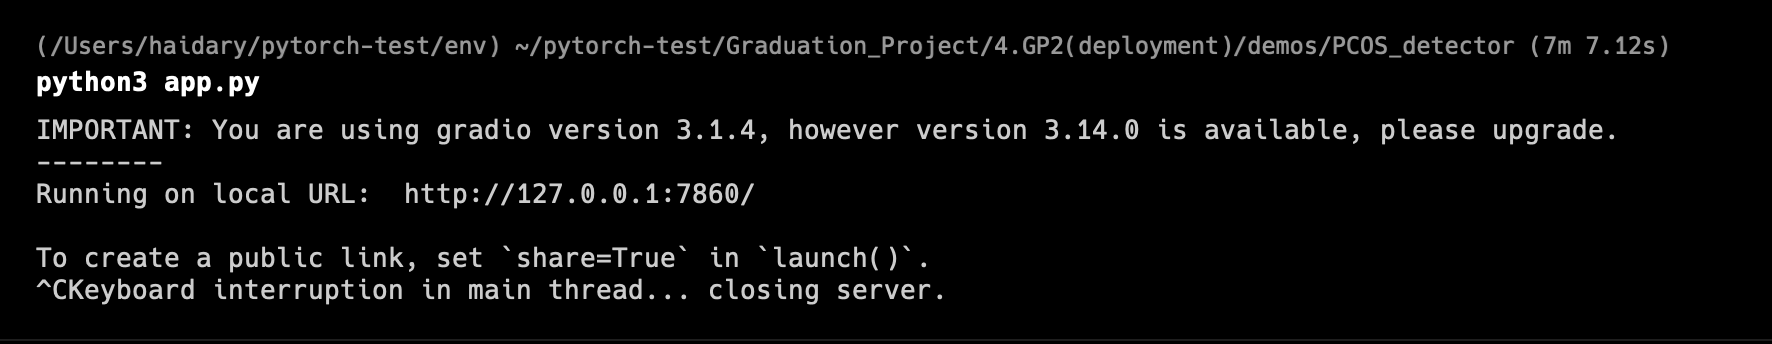

# After running the app like shown in the above image using the command: <br> `python3 app.py`, I copied the URL shown into the browser and the Gradio interface showed up as normal.
# Now after verifying that our app works locally, we must upload the code files into Hugging Face Spaces for it to work permantently and can be accessed from anywhere.